In [1]:
from collections import defaultdict
from time import sleep
from collections import namedtuple
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from tqdm import tqdm


import rcimport
import rankcentrality as rank
from rankcentrality import siamese

In [2]:
SimDataset = namedtuple("LSDataset", ["X", "scores", "method", "params"])

In [3]:
def make_lsdataset(n_points, n_dims):
    X = np.random.randn(n_points, n_dims)
    w = np.random.randn(n_dims, 1)
    w = w / np.linalg.norm(w)  # make w unit length
    scores = np.exp(w.T @ X.T).flatten()
    return SimDataset(X, scores, "linear", dict(w=w))

In [4]:
def make_nonlindataset(n_points, n_dims, n_w=3, poly_deg=2):
    X = np.random.randn(n_points, n_dims)
    scores = np.zeros((n_points, 1))
    ws = []
    polys = []
    for _ in range(n_w):
        w = np.random.randn(n_dims, 1)
        w = w / np.linalg.norm(w)  # make w unit length
        poly = np.random.randn(poly_deg)
        s = X @ w
        for exp in range(1, poly_deg + 1):
            scores += (poly[exp - 1] / exp) * (s ** (exp))
        ws.append(w)
        polys.append(poly)
    scores = np.exp(scores).flatten()
    return SimDataset(X, scores, "nonlinear", dict(ws=ws, polys=polys))

In [5]:
def make_absvaldataset(n_points, n_dims):
    X = np.random.randn(n_points, n_dims)
    w = np.random.randn(n_dims, 1)
    w = w / np.linalg.norm(w)  # make w unit length
    scores = np.exp(np.abs(w.T @ X.T)).flatten()
    return SimDataset(X, scores, "abs_linear", dict(w=w))

In [6]:
def make_nonlindataset2(n_points, n_dims, n_w=15):
    X = np.random.randn(n_points, n_dims)
    scores = np.zeros((n_points, 1))
    ws = []
    for _ in range(n_w):
        w = np.random.randn(n_dims, 1)
        w = w / np.linalg.norm(w)  # make w unit length
        s = X @ w
        scores += np.exp(s)
        ws.append(w)
    scores = np.exp(scores).flatten()
    return SimDataset(X, scores, "nonlinear2", dict(ws=ws))

In [7]:
def make_sindataset(n_points, n_dims, n_w=5):
    X = 4 * np.random.rand(n_points, n_dims)
    scores = np.zeros((n_points, 1))
    ws = []
    for _ in range(n_w):
        w = np.random.randn(n_dims, 1)
        # w = w / np.linalg.norm(w)  # make w unit length
        s = 5 * X @ w
        scores += np.exp(np.cos(s))
        ws.append(w)
    scores = np.exp(scores).flatten()
    return SimDataset(X, scores, "sinusoidal", dict(ws=ws))

In [8]:
def make_generaldataset(n_points, n_dims, n_cos_w=2, n_lin_w=2):
    X = 4 * np.random.rand(n_points, n_dims)
    scores = np.zeros((n_points, 1))
    cos_w = []
    for _ in range(n_cos_w):
        w = 5 * np.random.randn(n_dims, 1)
        s = X @ w
        scores += np.exp(np.cos(s))
        cos_w.append(w)
    lin_w = []
    for _ in range(n_lin_w):
        w = np.random.randn(n_dims, 1) / 10
        s = X @ w
        scores += np.exp(s)
        lin_w.append(w)
    scores = np.exp(scores).flatten()
    return SimDataset(X, scores, "nonlinear", dict(cos_w=cos_w, lin_w=lin_w))

In [9]:
np.random.seed(1234)  # to make results reproducible for discussions
# np.random.seed() # to let numpy seed random generator

## Impact of Kernel Width

In [10]:
experiment = 2

In [11]:
np.random.seed(1234)  # to make results reproducible for discussions
if experiment == 1:
    n_points = 1000
    X, scores, _, _ = make_sindataset(n_points, 1, n_w=1)
    kernel_width = 2 ** -4
    diff_time = 1
elif experiment == 2:
    n_points = 1600
    X, scores, _, _ = make_generaldataset(n_points, 2, 2, 2)
    kernel_width = 2 ** -5
    diff_time = 1
elif experiment == 3:
    n_points = 1000
    X, scores, _, _ = make_generaldataset(n_points, 10, 0, 5)
    kernel_width = 2 ** 0
    diff_time = 1

### Diffusion RankCentrality

In [12]:
scores_hat_diffrc = defaultdict(list)
widths_arr = [2 ** i for i in range(-10, 3)]
n_comps_arr = [(n_points // 10) * 2 ** i for i in range(1, 7)]
for n_comps in tqdm(n_comps_arr):
    sleep(0.01)
    comps, comp_results = rank.generate.simulate_comparisons(scores, n_comps)
    rc = rank.RankCentrality(n_points, comps, comp_results)
    for width in widths_arr:
        scores_hat_diffrc[n_comps].append(
            rc.run_diffused(X, width, lam=np.exp(-3))
        )

100%|██████████| 6/6 [01:59<00:00, 19.87s/it]


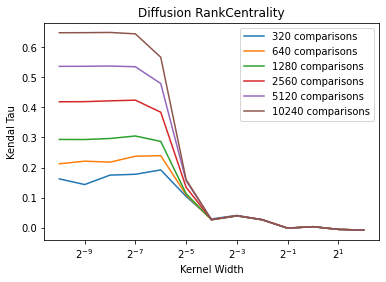

In [13]:
plt.figure()
plt.xscale("log", basex=2)
plt.title("Diffusion RankCentrality")
plt.xlabel("Kernel Width")
plt.ylabel("Kendal Tau")
for n_comps, scores_hat_dict in scores_hat_diffrc.items():
    plt.plot(
        widths_arr,
        [
            kendalltau(scores, scores_hat, method="asymptotic")[0]
            for scores_hat in scores_hat_dict
        ],
        label=f"{n_comps} comparisons",
    )
plt.legend()
plt.show()

In [14]:
diff_cols = {"widths": widths_arr}
for n_comps, scores_hat_dict in scores_hat_diffrc.items():
    diff_cols[f"{n_comps} comparisons"] = [
        kendalltau(scores, scores_hat, method="asymptotic")[0]
        for scores_hat in scores_hat_dict
    ]

In [15]:
diff_df = pd.DataFrame(diff_cols).set_index("widths")

In [16]:
diff_df

,320 comparisons,640 comparisons,1280 comparisons,2560 comparisons,5120 comparisons,10240 comparisons
widths,,,,,,
0.000977,0.162284,0.212395,0.293493,0.418768,0.536778,0.648620
0.001953,0.143422,0.221190,0.293215,0.419264,0.536984,0.648851
0.003906,0.174812,0.217950,0.296659,0.422020,0.537839,0.649619
0.007812,0.177635,0.237707,0.305016,0.424250,0.535443,0.644892
0.015625,0.192078,0.239480,0.286908,0.384148,0.479572,0.567065
0.031250,0.103841,0.109153,0.112892,0.134293,0.155553,0.159947
0.062500,0.028995,0.026401,0.025779,0.026606,0.026912,0.026801
0.125000,0.040725,0.039414,0.038926,0.039443,0.039404,0.039784
0.250000,0.026335,0.026159,0.025968,0.026518,0.026313,0.026649


In [17]:
diff_df.to_csv(f"../output/synthetic_exp{experiment}_variablewidths.csv")

### Decayed Diffusion RankCentrality

In [18]:
scores_hat_diffrc = defaultdict(list)
for n_comps in tqdm(n_comps_arr):
    sleep(0.01)
    comps, comp_results = rank.generate.simulate_comparisons(scores, n_comps)
    rc = rank.RankCentrality(n_points, comps, comp_results)
    for width in widths_arr:
        scores_hat_diffrc[n_comps].append(
            rc.run_diffused_decayed(X, width, lam=np.exp(-3))
        )

100%|██████████| 6/6 [02:03<00:00, 20.59s/it]


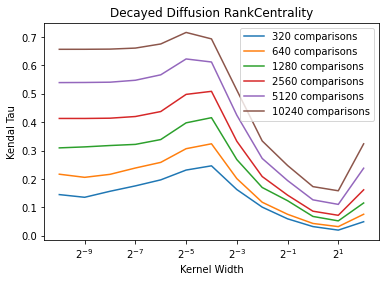

In [19]:
plt.figure()
plt.xscale("log", basex=2)
plt.title("Decayed Diffusion RankCentrality")
plt.xlabel("Kernel Width")
plt.ylabel("Kendal Tau")
for n_comps, scores_hat_dict in scores_hat_diffrc.items():
    plt.plot(
        widths_arr,
        [
            kendalltau(scores, scores_hat, method="asymptotic")[0]
            for scores_hat in scores_hat_dict
        ],
        label=f"{n_comps} comparisons",
    )
plt.legend()
plt.show()

In [20]:
diff_cols = {"widths": widths_arr}
for n_comps, scores_hat_dict in scores_hat_diffrc.items():
    diff_cols[f"{n_comps} comparisons"] = [
        kendalltau(scores, scores_hat, method="asymptotic")[0]
        for scores_hat in scores_hat_dict
    ]

In [21]:
diff_df = pd.DataFrame(diff_cols).set_index("widths")

In [22]:
diff_df

,320 comparisons,640 comparisons,1280 comparisons,2560 comparisons,5120 comparisons,10240 comparisons
widths,,,,,,
0.000977,0.145171,0.216920,0.309604,0.413189,0.539407,0.656606
0.001953,0.135675,0.205920,0.313081,0.413174,0.539837,0.656692
0.003906,0.156849,0.216473,0.317903,0.414115,0.540846,0.657261
0.007812,0.175831,0.238746,0.321908,0.419993,0.547675,0.660896
0.015625,0.197027,0.258577,0.338926,0.437513,0.566773,0.675414
0.031250,0.231538,0.306748,0.397735,0.497941,0.622641,0.715957
0.062500,0.246426,0.323996,0.415907,0.508643,0.611909,0.693250
0.125000,0.162888,0.201404,0.268397,0.332850,0.424553,0.512814
0.250000,0.101107,0.118282,0.170169,0.208738,0.272398,0.334065


In [23]:
diff_df.to_csv(
    f"../output/synthetic_exp{experiment}_variablewidths_decayed.csv"
)

## Comparison of Algorithms Using Pairwise Comparisons With Features

In [24]:
n_comps_arr = np.array((n_points // 10) * (2 ** np.arange(8)))
n_comps_arr

array([  160,   320,   640,  1280,  2560,  5120, 10240, 20480])

In [25]:
num_draws = 20
what_dict = defaultdict(lambda: [[] for _ in n_comps_arr])
for m_ind, n_comps in enumerate(tqdm(n_comps_arr, desc="num_comps")):
    for _ in range(
        num_draws
    ):  # tqdm(range(num_draws), desc="draws", leave=False):
        sleep(0.00001)  # odd ARPACK errors without this...
        comps, comp_results = rank.generate.simulate_comparisons(
            scores, n_comps
        )
        rc = rank.RankCentrality(n_points, comps, comp_results)
        what_dict["regRC"][m_ind].append(rc.run_regularized(1 / n_points))
        what_dict["diffRC_decay"][m_ind].append(
            rc.run_diffused_decayed(X, kernel_width, lam=1 / n_points)
        )
        btl = rank.BTLMLE(n_points, comps, comp_results)
        what_dict["BTL-MLE-reg"][m_ind].append(btl.run(C=1))
        ranksvm = rank.RankSVM(n_points, comps, comp_results, X)
        what_dict["RankSVM"][m_ind].append(ranksvm.run())
        ranksvm_rf = rank.RankSVM(n_points, comps, comp_results, X)
        what_dict["RF-RankSVM"][m_ind].append(ranksvm_rf.run_random_features())
        snn = siamese.SiameseNetRank(n_points, comps, comp_results, X)
        what_dict["SNN"][m_ind].append(snn.run())

num_comps: 100%|██████████| 8/8 [09:05<00:00, 68.21s/it]


In [26]:
loss = "kt"

In [27]:
metrics = rank.stats.compute_experiment_metrics(
    what_dict, scores, loss, len(n_comps_arr), num_draws
)

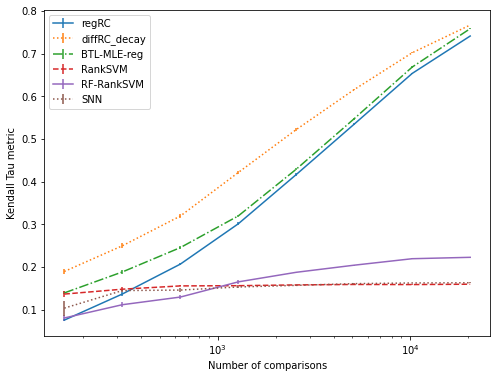

In [28]:
f, ax = rank.stats.plot_experiment_metrics(metrics, n_comps_arr, loss)
f.set_figheight(6)
f.set_figwidth(8)

In [29]:
df = rank.stats.experiment_metrics_to_dataframe(metrics, n_comps_arr)
df

,regRC,regRC_std_err,diffRC_decay,diffRC_decay_std_err,BTL-MLE-reg,BTL-MLE-reg_std_err,RankSVM,RankSVM_std_err,RF-RankSVM,RF-RankSVM_std_err,SNN,SNN_std_err
num_comps,,,,,,,,,,,,
160,0.076048,0.002533,0.189995,0.006812,0.139779,0.003717,0.137001,0.006660,0.081011,0.006442,0.104087,0.017785
320,0.137130,0.003723,0.250081,0.006160,0.188807,0.004061,0.148413,0.004032,0.112082,0.005906,0.145255,0.003817
640,0.207110,0.003140,0.319703,0.004683,0.245809,0.003192,0.156118,0.001266,0.129988,0.005597,0.146355,0.004312
1280,0.301602,0.003140,0.421741,0.003084,0.320046,0.003032,0.156629,0.001164,0.165572,0.003970,0.153618,0.002644
2560,0.417024,0.003099,0.522309,0.003782,0.429487,0.002913,0.158448,0.000511,0.188013,0.001703,0.157407,0.000960
5120,0.535070,0.002281,0.616019,0.001970,0.547843,0.002008,0.159521,0.000279,0.204668,0.001223,0.161412,0.000571
10240,0.653837,0.001755,0.702223,0.001667,0.668731,0.001554,0.159253,0.000249,0.219821,0.001378,0.163015,0.000576
20480,0.741406,0.000711,0.767173,0.000844,0.758653,0.000869,0.160103,0.000125,0.223089,0.001298,0.163534,0.000855


In [30]:
df.to_csv(
    f"../output/synthetic_exp{experiment}_width{kernel_width}_draws{num_draws}.csv"
)